## 📦 Part 1: Setup and Installation

Installing required libraries for transformer models, data processing, and visualization.

In [1]:
# Install required packages
!pip install -q transformers
!pip install -q datasets
!pip install -q scikit-learn
!pip install -q seaborn
!pip install -q tqdm
!pip install -q accelerate

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


## 📚 Part 2: Import Libraries

In [2]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
    set_seed
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Set random seeds for reproducibility
SEED = 42
set_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
print(f"🎲 Random seed: {SEED}")

if torch.cuda.is_available():
    print(f"💻 GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🚀 Device: cuda
🎲 Random seed: 42
💻 GPU: Tesla T4
📊 Memory: 15.83 GB


## ⚙️ Part 3: Configuration

Define all hyperparameters and settings in a structured configuration class.

In [3]:
@dataclass
class Config:
    """Configuration for DimASR task"""

    # Task Configuration
    subtask: str = "subtask_1"
    track: str = "track_a"
    language: str = "eng"  # Options: eng, jpn, rus, tat, ukr, zho
    domain: str = "restaurant"  # Options: restaurant, laptop, hotel, finance

    # Model Configuration
    model_name: str = "bert-base-multilingual-cased"
    # Alternative models to try:
    # - "xlm-roberta-base"
    # - "microsoft/mdeberta-v3-base"
    # - "bert-base-uncased" (for English only)
    # - "roberta-base" (for English only)

    # Training Hyperparameters
    max_length: int = 128
    batch_size: int = 16
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    num_epochs: int = 5
    warmup_ratio: float = 0.1
    gradient_clip: float = 1.0

    # Data Split
    val_split: float = 0.1

    # Output Configuration
    output_dir: str = "./outputs"
    save_best_model: bool = True

    # Advanced Settings
    dropout_rate: float = 0.1
    use_scheduler: bool = True
    scheduler_type: str = "linear"  # Options: linear, cosine, plateau

    # VA score constraints
    va_min: float = 1.0
    va_max: float = 9.0

    def __post_init__(self):
        """Create output directory and build URLs"""
        os.makedirs(self.output_dir, exist_ok=True)

        # Build data URLs
        base_url = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
        self.train_url = f"{base_url}/{self.track}/{self.subtask}/{self.language}/{self.language}_{self.domain}_train_alltasks.jsonl"
        self.dev_url = f"{base_url}/{self.track}/{self.subtask}/{self.language}/{self.language}_{self.domain}_dev_task1.jsonl"

    def display(self):
        """Display configuration"""
        print("=" * 60)
        print("🔧 CONFIGURATION")
        print("=" * 60)
        for key, value in self.__dict__.items():
            if not key.endswith('_url'):
                print(f"{key:20s}: {value}")
        print("=" * 60)

# Initialize configuration
config = Config()
config.display()

🔧 CONFIGURATION
subtask             : subtask_1
track               : track_a
language            : eng
domain              : restaurant
model_name          : bert-base-multilingual-cased
max_length          : 128
batch_size          : 16
learning_rate       : 2e-05
weight_decay        : 0.01
num_epochs          : 5
warmup_ratio        : 0.1
gradient_clip       : 1.0
val_split           : 0.1
output_dir          : ./outputs
save_best_model     : True
dropout_rate        : 0.1
use_scheduler       : True
scheduler_type      : linear
va_min              : 1.0
va_max              : 9.0


## 📊 Part 4: Data Loading and Processing

Load JSONL data from GitHub and convert to structured DataFrames.

In [4]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Load JSONL data from URL.

    Args:
        url: URL to JSONL file

    Returns:
        List of dictionaries
    """
    import urllib.request

    try:
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            return [json.loads(line) for line in data.strip().split('\n') if line.strip()]
    except Exception as e:
        print(f"❌ Error loading data from {url}: {e}")
        raise


def jsonl_to_dataframe(data: List[Dict]) -> pd.DataFrame:
    """
    Convert JSONL data to pandas DataFrame.

    Handles different data formats:
    - Quadruplet (Task 3): has 'Quadruplet' field
    - Triplet (Task 2): has 'Triplet' field
    - Aspect_VA (Task 1 with labels): has 'Aspect_VA' field
    - Aspect (Task 1 without labels): has 'Aspect' field

    Args:
        data: List of dictionaries from JSONL

    Returns:
        DataFrame with columns: ID, Text, Aspect, Valence, Arousal
    """
    if not data:
        raise ValueError("Empty data list")

    first_item = data[0]

    # Quadruplet format (Task 3)
    if 'Quadruplet' in first_item:
        df = pd.json_normalize(data, 'Quadruplet', ['ID', 'Text'])
        df[['Valence', 'Arousal']] = df['VA'].str.split('#', expand=True).astype(float)
        df = df.drop(columns=['VA', 'Category', 'Opinion'], errors='ignore')

    # Triplet format (Task 2)
    elif 'Triplet' in first_item:
        df = pd.json_normalize(data, 'Triplet', ['ID', 'Text'])
        df[['Valence', 'Arousal']] = df['VA'].str.split('#', expand=True).astype(float)
        df = df.drop(columns=['VA', 'Opinion'], errors='ignore')

    # Aspect_VA format (Task 1 with labels)
    elif 'Aspect_VA' in first_item:
        df = pd.json_normalize(data, 'Aspect_VA', ['ID', 'Text'])
        df = df.rename(columns={df.columns[0]: 'Aspect'})
        df[['Valence', 'Arousal']] = df['VA'].str.split('#', expand=True).astype(float)
        df = df.drop(columns=['VA'], errors='ignore')

    # Aspect format (Task 1 without labels - test set)
    elif 'Aspect' in first_item:
        df = pd.json_normalize(data, 'Aspect', ['ID', 'Text'])
        df = df.rename(columns={df.columns[0]: 'Aspect'})
        df['Valence'] = 0.0  # Placeholder
        df['Arousal'] = 0.0  # Placeholder

    else:
        raise ValueError("Unknown data format. Expected 'Quadruplet', 'Triplet', 'Aspect_VA', or 'Aspect'")

    # Remove duplicates (same ID + Aspect)
    df = df.drop_duplicates(subset=['ID', 'Aspect'], keep='first')

    # Reset index
    df = df.reset_index(drop=True)

    return df


def load_and_process_data(config: Config) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load and split data into train/val/test.

    Args:
        config: Configuration object

    Returns:
        train_df, val_df, test_df
    """
    print("\n" + "=" * 60)
    print("📥 LOADING DATA")
    print("=" * 60)

    # Load training data
    print(f"Loading training data from: {config.train_url}")
    train_raw = load_jsonl_from_url(config.train_url)
    train_df = jsonl_to_dataframe(train_raw)
    print(f"✅ Training data loaded: {len(train_df)} samples")

    # Load test data (dev set for evaluation)
    print(f"\nLoading test data from: {config.dev_url}")
    test_raw = load_jsonl_from_url(config.dev_url)
    test_df = jsonl_to_dataframe(test_raw)
    print(f"✅ Test data loaded: {len(test_df)} samples")

    # Split training data into train/val
    train_df, val_df = train_test_split(
        train_df,
        test_size=config.val_split,
        random_state=SEED,
        shuffle=True
    )

    print(f"\n📊 Data Split:")
    print(f"  - Train: {len(train_df)} samples")
    print(f"  - Val:   {len(val_df)} samples")
    print(f"  - Test:  {len(test_df)} samples")

    return train_df, val_df, test_df


# Load data
train_df, val_df, test_df = load_and_process_data(config)


📥 LOADING DATA
Loading training data from: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_1/eng/eng_restaurant_train_alltasks.jsonl
✅ Training data loaded: 3107 samples

Loading test data from: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_1/eng/eng_restaurant_dev_task1.jsonl
✅ Test data loaded: 340 samples

📊 Data Split:
  - Train: 2796 samples
  - Val:   311 samples
  - Test:  340 samples


## 🔍 Part 5: Exploratory Data Analysis (EDA)

Analyze the data distribution, VA scores, and aspects.

In [5]:
def perform_eda(df: pd.DataFrame, title: str = "Dataset"):
    """
    Perform exploratory data analysis.

    Args:
        df: DataFrame to analyze
        title: Title for plots
    """
    print("\n" + "=" * 60)
    print(f"📈 EDA: {title}")
    print("=" * 60)

    # Basic statistics
    print(f"\n📊 Shape: {df.shape}")
    print(f"\n📋 Columns: {df.columns.tolist()}")

    # Check for missing values
    print(f"\n❓ Missing values:")
    print(df.isnull().sum())

    # VA statistics
    if 'Valence' in df.columns and df['Valence'].sum() > 0:
        print(f"\n📉 Valence statistics:")
        print(df['Valence'].describe())

        print(f"\n📉 Arousal statistics:")
        print(df['Arousal'].describe())

        # Text length
        df['text_length'] = df['Text'].str.len()
        df['word_count'] = df['Text'].str.split().str.len()

        print(f"\n📏 Text length statistics:")
        print(df['text_length'].describe())

        print(f"\n📝 Word count statistics:")
        print(df['word_count'].describe())

        # Sample data
        print(f"\n🔬 Sample data:")
        print(df[['Text', 'Aspect', 'Valence', 'Arousal']].head(3))

    return df


# Perform EDA on all datasets
train_df = perform_eda(train_df, "Training Set")
val_df = perform_eda(val_df, "Validation Set")
test_df = perform_eda(test_df, "Test Set")


📈 EDA: Training Set

📊 Shape: (2796, 5)

📋 Columns: ['Aspect', 'ID', 'Text', 'Valence', 'Arousal']

❓ Missing values:
Aspect     0
ID         0
Text       0
Valence    0
Arousal    0
dtype: int64

📉 Valence statistics:
count    2796.000000
mean        6.240833
std         1.794204
min         1.170000
25%         5.000000
50%         7.000000
75%         7.670000
max         9.000000
Name: Valence, dtype: float64

📉 Arousal statistics:
count    2796.000000
mean        6.813813
std         1.145980
min         3.830000
25%         5.830000
50%         7.120000
75%         7.750000
max         9.000000
Name: Arousal, dtype: float64

📏 Text length statistics:
count    2796.000000
mean       80.864449
std        54.963425
min         2.000000
25%        44.000000
50%        69.000000
75%       104.000000
max       399.000000
Name: text_length, dtype: float64

📝 Word count statistics:
count    2796.000000
mean       17.190629
std        11.906755
min         1.000000
25%         9.000000
5

## 📊 Part 6: Data Visualization

Visualize VA score distributions and correlations.

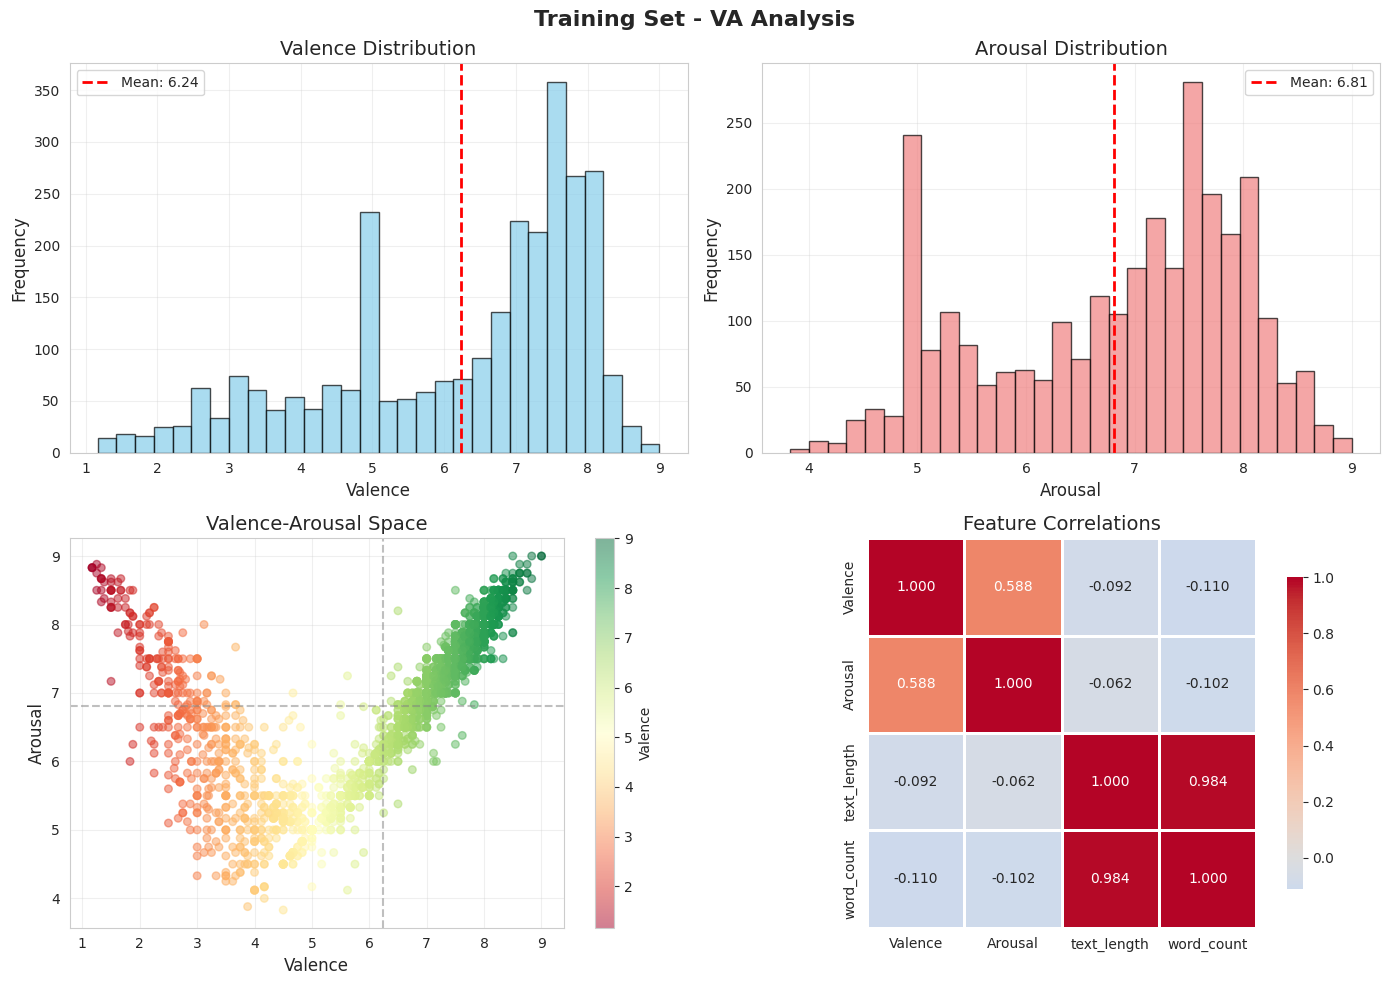


📊 Training Set VA Statistics:
  Valence: 1.17 - 9.00 (mean: 6.24)
  Arousal: 3.83 - 9.00 (mean: 6.81)
  Correlation (V-A): 0.588


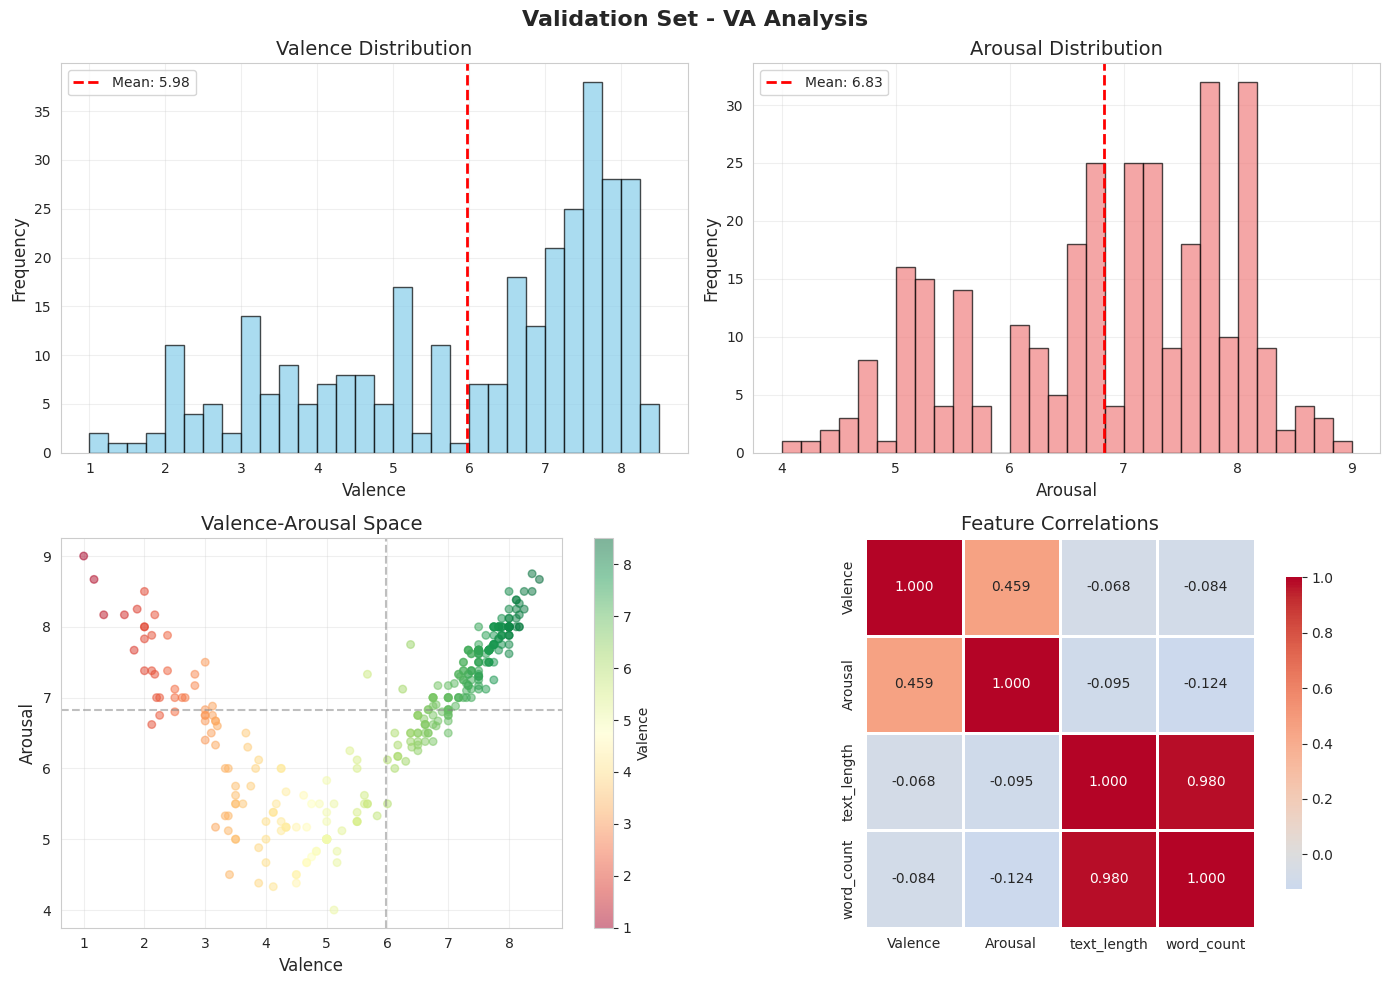


📊 Validation Set VA Statistics:
  Valence: 1.00 - 8.50 (mean: 5.98)
  Arousal: 4.00 - 9.00 (mean: 6.83)
  Correlation (V-A): 0.459


In [6]:
def visualize_va_distribution(df: pd.DataFrame, title: str = "Dataset"):
    """
    Visualize Valence-Arousal distribution.

    Args:
        df: DataFrame with Valence and Arousal columns
        title: Title for the plot
    """
    if 'Valence' not in df.columns or df['Valence'].sum() == 0:
        print(f"⚠️ Skipping visualization for {title} (no VA labels)")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title} - VA Analysis', fontsize=16, fontweight='bold')

    # 1. Valence distribution
    axes[0, 0].hist(df['Valence'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df['Valence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Valence"].mean():.2f}')
    axes[0, 0].set_xlabel('Valence', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Valence Distribution', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Arousal distribution
    axes[0, 1].hist(df['Arousal'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(df['Arousal'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Arousal"].mean():.2f}')
    axes[0, 1].set_xlabel('Arousal', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Arousal Distribution', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. VA scatter plot
    scatter = axes[1, 0].scatter(df['Valence'], df['Arousal'], alpha=0.5, c=df['Valence'], cmap='RdYlGn', s=30)
    axes[1, 0].set_xlabel('Valence', fontsize=12)
    axes[1, 0].set_ylabel('Arousal', fontsize=12)
    axes[1, 0].set_title('Valence-Arousal Space', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 0], label='Valence')

    # Add quadrants
    v_mean, a_mean = df['Valence'].mean(), df['Arousal'].mean()
    axes[1, 0].axvline(v_mean, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(a_mean, color='gray', linestyle='--', alpha=0.5)

    # 4. Correlation heatmap
    if 'text_length' in df.columns:
        corr_data = df[['Valence', 'Arousal', 'text_length', 'word_count']].corr()
        sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                   ax=axes[1, 1], square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        axes[1, 1].set_title('Feature Correlations', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 {title} VA Statistics:")
    print(f"  Valence: {df['Valence'].min():.2f} - {df['Valence'].max():.2f} (mean: {df['Valence'].mean():.2f})")
    print(f"  Arousal: {df['Arousal'].min():.2f} - {df['Arousal'].max():.2f} (mean: {df['Arousal'].mean():.2f})")
    print(f"  Correlation (V-A): {df['Valence'].corr(df['Arousal']):.3f}")


# Visualize training data
visualize_va_distribution(train_df, "Training Set")
visualize_va_distribution(val_df, "Validation Set")

## 🏗️ Part 7: Dataset Class

Create custom PyTorch Dataset for VA regression.

In [8]:
class VADataset(Dataset):
    """
    PyTorch Dataset for Valence-Arousal regression.

    Combines aspect and text into a single input string:
    Format: "[CLS] aspect: {aspect} [SEP] text: {text}"

    Args:
        dataframe: DataFrame with columns [Text, Aspect, Valence, Arousal]
        tokenizer: HuggingFace tokenizer
        max_length: Maximum sequence length
        is_test: Whether this is test data (no labels)
    """

    def __init__(
        self,
        dataframe: pd.DataFrame,
        tokenizer,
        max_length: int = 128,
        is_test: bool = False
    ):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a single sample.

        Returns:
            Dictionary with:
            - input_ids: Token IDs
            - attention_mask: Attention mask
            - labels: [Valence, Arousal] (if not test)
        """
        row = self.data.iloc[idx]

        # Construct input text
        aspect = str(row['Aspect'])
        text = str(row['Text'])

        # Tokenize
        encoding = self.tokenizer(
            f"aspect: {aspect}",
            f"text: {text}",
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        # Add labels if not test
        if not self.is_test:
            valence = float(row['Valence'])
            arousal = float(row['Arousal'])
            item['labels'] = torch.tensor([valence, arousal], dtype=torch.float32)

        return item


# Initialize tokenizer
print("\n" + "=" * 60)
print("🔤 INITIALIZING TOKENIZER")
print("=" * 60)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
print(f"✅ Tokenizer loaded: {config.model_name}")
print(f"📏 Vocab size: {tokenizer.vocab_size}")

# Create datasets
train_dataset = VADataset(train_df, tokenizer, config.max_length, is_test=False)
val_dataset = VADataset(val_df, tokenizer, config.max_length, is_test=False)
test_dataset = VADataset(test_df, tokenizer, config.max_length, is_test=True)

print(f"\n✅ Datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val:   {len(val_dataset)} samples")
print(f"  - Test:  {len(test_dataset)} samples")

# Test dataset
print(f"\n🔬 Sample from training dataset:")
sample = train_dataset[0]
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
if 'labels' in sample:
    print(f"  Labels: {sample['labels']}")
print(f"  Decoded text: {tokenizer.decode(sample['input_ids'], skip_special_tokens=True)[:100]}...")


🔤 INITIALIZING TOKENIZER
✅ Tokenizer loaded: bert-base-multilingual-cased
📏 Vocab size: 119547

✅ Datasets created:
  - Train: 2796 samples
  - Val:   311 samples
  - Test:  340 samples

🔬 Sample from training dataset:
  Input IDs shape: torch.Size([128])
  Attention mask shape: torch.Size([128])
  Labels: tensor([8.2500, 8.3800])
  Decoded text: aspect : winelist text : seattle ' s best winelist...


## 🔧 Part 8: DataLoader Creation

Create efficient DataLoaders for training and evaluation.

In [9]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\n" + "=" * 60)
print("📦 DATALOADERS CREATED")
print("=" * 60)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

# Test a batch
print(f"\n🔬 Sample batch:")
batch = next(iter(train_loader))
print(f"  Input IDs shape: {batch['input_ids'].shape}")
print(f"  Attention mask shape: {batch['attention_mask'].shape}")
print(f"  Labels shape: {batch['labels'].shape}")


📦 DATALOADERS CREATED
Train batches: 175
Val batches:   20
Test batches:  22

🔬 Sample batch:
  Input IDs shape: torch.Size([16, 128])
  Attention mask shape: torch.Size([16, 128])
  Labels shape: torch.Size([16, 2])


## 🧠 Part 9: Model Architecture

Define a sophisticated VA regression model with:
- Pretrained transformer backbone
- Multi-layer regression head
- Dropout regularization
- Output clamping to [1, 9] range

In [10]:
class VARegressor(nn.Module):
    """
    Valence-Arousal Regressor based on pretrained transformers.

    Architecture:
    1. Pretrained transformer (BERT, RoBERTa, XLM-R, etc.)
    2. Dropout for regularization
    3. Multi-layer feedforward network
    4. Two output heads: one for Valence, one for Arousal
    5. Output clamping to [1, 9] range

    Args:
        model_name: HuggingFace model name
        dropout_rate: Dropout probability
        va_min: Minimum VA value (default: 1.0)
        va_max: Maximum VA value (default: 9.0)
    """

    def __init__(
        self,
        model_name: str,
        dropout_rate: float = 0.1,
        va_min: float = 1.0,
        va_max: float = 9.0
    ):
        super(VARegressor, self).__init__()

        self.va_min = va_min
        self.va_max = va_max

        # Load pretrained transformer
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)

        hidden_size = self.config.hidden_size

        # Regression head
        self.dropout = nn.Dropout(dropout_rate)

        # Two-layer feedforward network
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.activation = nn.GELU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Separate heads for Valence and Arousal
        self.valence_head = nn.Linear(hidden_size // 2, 1)
        self.arousal_head = nn.Linear(hidden_size // 2, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize regression head weights"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.valence_head.weight)
        nn.init.zeros_(self.valence_head.bias)
        nn.init.xavier_uniform_(self.arousal_head.weight)
        nn.init.zeros_(self.arousal_head.bias)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass.

        Args:
            input_ids: Token IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]

        Returns:
            Predictions [batch_size, 2] where [:, 0] is Valence and [:, 1] is Arousal
        """
        # Get transformer outputs
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Feedforward network
        hidden = self.fc1(pooled_output)
        hidden = self.activation(hidden)
        hidden = self.dropout2(hidden)

        # Separate predictions
        valence = self.valence_head(hidden)  # [batch_size, 1]
        arousal = self.arousal_head(hidden)  # [batch_size, 1]

        # Concatenate and clamp to [va_min, va_max]
        predictions = torch.cat([valence, arousal], dim=1)  # [batch_size, 2]
        predictions = torch.clamp(predictions, self.va_min, self.va_max)

        return predictions


# Initialize model
print("\n" + "=" * 60)
print("🧠 INITIALIZING MODEL")
print("=" * 60)

model = VARegressor(
    model_name=config.model_name,
    dropout_rate=config.dropout_rate,
    va_min=config.va_min,
    va_max=config.va_max
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model: {config.model_name}")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,}")
print(f"💾 Model size: {total_params * 4 / 1e6:.2f} MB")

# Test forward pass
print(f"\n🔬 Testing forward pass...")
batch = next(iter(train_loader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    print(f"✅ Output shape: {outputs.shape}")
    print(f"✅ Sample predictions: {outputs[0].cpu().numpy()}")
    print(f"✅ Value range: [{outputs.min():.2f}, {outputs.max():.2f}]")


🧠 INITIALIZING MODEL


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

✅ Model: bert-base-multilingual-cased
📊 Total parameters: 178,149,506
🎯 Trainable parameters: 178,149,506
💾 Model size: 712.60 MB

🔬 Testing forward pass...
✅ Output shape: torch.Size([16, 2])
✅ Sample predictions: [1. 1.]
✅ Value range: [1.00, 1.00]


## 📐 Part 10: Loss Function and Metrics

Define custom loss function and evaluation metrics.

In [11]:
class VALoss(nn.Module):
    """
    Custom loss function for VA regression.

    Combines MSE loss for Valence and Arousal with optional weighting.

    Args:
        valence_weight: Weight for valence loss (default: 1.0)
        arousal_weight: Weight for arousal loss (default: 1.0)
    """

    def __init__(self, valence_weight: float = 1.0, arousal_weight: float = 1.0):
        super(VALoss, self).__init__()
        self.valence_weight = valence_weight
        self.arousal_weight = arousal_weight
        self.mse = nn.MSELoss()

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Compute loss.

        Args:
            predictions: Predicted VA scores [batch_size, 2]
            targets: True VA scores [batch_size, 2]

        Returns:
            Scalar loss value
        """
        valence_loss = self.mse(predictions[:, 0], targets[:, 0])
        arousal_loss = self.mse(predictions[:, 1], targets[:, 1])

        total_loss = (
            self.valence_weight * valence_loss +
            self.arousal_weight * arousal_loss
        )

        return total_loss


def compute_rmse(predictions: np.ndarray, targets: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute RMSE for VA prediction.

    RMSE_VA = sqrt(sum((V_pred - V_true)^2 + (A_pred - A_true)^2) / N)

    Args:
        predictions: Predicted VA scores [N, 2]
        targets: True VA scores [N, 2]

    Returns:
        rmse_combined: Combined RMSE for both V and A
        rmse_valence: RMSE for Valence only
        rmse_arousal: RMSE for Arousal only
    """
    # Separate valence and arousal
    v_pred, a_pred = predictions[:, 0], predictions[:, 1]
    v_true, a_true = targets[:, 0], targets[:, 1]

    # Compute RMSE for each
    rmse_valence = np.sqrt(mean_squared_error(v_true, v_pred))
    rmse_arousal = np.sqrt(mean_squared_error(a_true, a_pred))

    # Combined RMSE (official metric)
    squared_errors = (v_pred - v_true) ** 2 + (a_pred - a_true) ** 2
    rmse_combined = np.sqrt(np.mean(squared_errors))

    return rmse_combined, rmse_valence, rmse_arousal


# Initialize loss function
criterion = VALoss(valence_weight=1.0, arousal_weight=1.0)

print("\n" + "=" * 60)
print("📐 LOSS FUNCTION AND METRICS")
print("=" * 60)
print(f"✅ Loss: Custom VA Loss (MSE-based)")
print(f"✅ Metric: RMSE_VA = sqrt(sum((V_p - V_t)^2 + (A_p - A_t)^2) / N)")

# Test loss computation
with torch.no_grad():
    batch = next(iter(train_loader))
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    predictions = model(input_ids, attention_mask)
    loss = criterion(predictions, labels)

    print(f"\n🔬 Test loss computation:")
    print(f"  Loss value: {loss.item():.4f}")

    # Test RMSE
    pred_np = predictions.cpu().numpy()
    label_np = labels.cpu().numpy()
    rmse_combined, rmse_v, rmse_a = compute_rmse(pred_np, label_np)

    print(f"  RMSE (combined): {rmse_combined:.4f}")
    print(f"  RMSE (valence):  {rmse_v:.4f}")
    print(f"  RMSE (arousal):  {rmse_a:.4f}")


📐 LOSS FUNCTION AND METRICS
✅ Loss: Custom VA Loss (MSE-based)
✅ Metric: RMSE_VA = sqrt(sum((V_p - V_t)^2 + (A_p - A_t)^2) / N)

🔬 Test loss computation:
  Loss value: 67.9785
  RMSE (combined): 8.2449
  RMSE (valence):  5.6611
  RMSE (arousal):  5.9942


---

## ✅ Part 1 Complete!

**Summary of Part 1:**
1. ✅ Setup and installation
2. ✅ Data loading and preprocessing
3. ✅ Exploratory data analysis
4. ✅ Dataset and DataLoader creation
5. ✅ Model architecture definition
6. ✅ Loss function and metrics

**Next Steps (Part 2):**
- Optimizer and scheduler setup
- Training loop with progress tracking
- Validation and evaluation
- Model checkpointing
- Prediction generation
- Submission file creation

---

---

# 🚀 PART 2: Training, Evaluation & Submission

---

## 🔧 Part 11: Optimizer and Scheduler Setup

Configure optimizer with weight decay and learning rate scheduler.

In [ ]:
# Prepare optimizer with layer-wise learning rate decay (optional)
# Separate parameters: transformer backbone vs regression head
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.transformer.named_parameters()
                   if not any(nd in n for nd in no_decay)],
        'weight_decay': config.weight_decay,
        'lr': config.learning_rate
    },
    {
        'params': [p for n, p in model.transformer.named_parameters()
                   if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': config.learning_rate
    },
    {
        'params': [p for n, p in model.named_parameters()
                   if 'transformer' not in n and not any(nd in n for nd in no_decay)],
        'weight_decay': config.weight_decay,
        'lr': config.learning_rate * 10  # Higher LR for regression head
    },
    {
        'params': [p for n, p in model.named_parameters()
                   if 'transformer' not in n and any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': config.learning_rate * 10
    }
]

optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)

# Calculate total training steps
total_steps = len(train_loader) * config.num_epochs
warmup_steps = int(total_steps * config.warmup_ratio)

# Create scheduler
if config.use_scheduler:
    if config.scheduler_type == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    elif config.scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=total_steps,
            eta_min=1e-7
        )
    elif config.scheduler_type == 'plateau':
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )
else:
    scheduler = None

print("\n" + "=" * 60)
print("🔧 OPTIMIZER AND SCHEDULER")
print("=" * 60)
print(f"✅ Optimizer: AdamW")
print(f"  - Learning rate: {config.learning_rate}")
print(f"  - Weight decay: {config.weight_decay}")
print(f"  - Regression head LR: {config.learning_rate * 10}")
print(f"\n✅ Scheduler: {config.scheduler_type if config.use_scheduler else 'None'}")
print(f"  - Total steps: {total_steps}")
print(f"  - Warmup steps: {warmup_steps}")
print(f"  - Warmup ratio: {config.warmup_ratio}")
print("=" * 60)

## 🏋️ Part 12: Training and Validation Functions

Define comprehensive training and validation functions with progress tracking.

In [ ]:
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[object],
    device: torch.device,
    epoch: int,
    gradient_clip: float = 1.0
) -> Tuple[float, float, float, float]:
    """
    Train for one epoch.

    Args:
        model: VA regression model
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to train on
        epoch: Current epoch number
        gradient_clip: Max gradient norm

    Returns:
        avg_loss, rmse_combined, rmse_valence, rmse_arousal
    """
    model.train()

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

        # Optimizer step
        optimizer.step()

        # Scheduler step (if not plateau)
        if scheduler is not None and config.scheduler_type != 'plateau':
            scheduler.step()

        # Accumulate metrics
        total_loss += loss.item()
        all_predictions.append(predictions.detach().cpu().numpy())
        all_targets.append(labels.detach().cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    rmse_combined, rmse_valence, rmse_arousal = compute_rmse(all_predictions, all_targets)

    return avg_loss, rmse_combined, rmse_valence, rmse_arousal


def validate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float, float, float, np.ndarray, np.ndarray]:
    """
    Validate the model.

    Args:
        model: VA regression model
        dataloader: Validation data loader
        criterion: Loss function
        device: Device to validate on

    Returns:
        avg_loss, rmse_combined, rmse_valence, rmse_arousal, predictions, targets
    """
    model.eval()

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)

            # Accumulate metrics
            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    rmse_combined, rmse_valence, rmse_arousal = compute_rmse(all_predictions, all_targets)

    return avg_loss, rmse_combined, rmse_valence, rmse_arousal, all_predictions, all_targets


print("\n✅ Training and validation functions defined!")

## 🎯 Part 13: Main Training Loop

Execute the complete training process with checkpointing and early stopping.

In [ ]:
# Training history tracking
history = {
    'train_loss': [],
    'train_rmse': [],
    'train_rmse_v': [],
    'train_rmse_a': [],
    'val_loss': [],
    'val_rmse': [],
    'val_rmse_v': [],
    'val_rmse_a': [],
    'learning_rates': []
}

best_val_rmse = float('inf')
best_epoch = 0
patience_counter = 0
early_stop_patience = 3

print("\n" + "=" * 60)
print("🎯 STARTING TRAINING")
print("=" * 60)
print(f"Total epochs: {config.num_epochs}")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print("=" * 60)

for epoch in range(1, config.num_epochs + 1):
    print(f"\n{'='*60}")
    print(f"📍 EPOCH {epoch}/{config.num_epochs}")
    print(f"{'='*60}")

    # Training
    train_loss, train_rmse, train_rmse_v, train_rmse_a = train_epoch(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epoch=epoch,
        gradient_clip=config.gradient_clip
    )

    # Validation
    val_loss, val_rmse, val_rmse_v, val_rmse_a, val_preds, val_targets = validate(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )

    # Learning rate (get first param group)
    current_lr = optimizer.param_groups[0]['lr']

    # Update scheduler (if plateau)
    if scheduler is not None and config.scheduler_type == 'plateau':
        scheduler.step(val_rmse)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_rmse'].append(train_rmse)
    history['train_rmse_v'].append(train_rmse_v)
    history['train_rmse_a'].append(train_rmse_a)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_rmse_v'].append(val_rmse_v)
    history['val_rmse_a'].append(val_rmse_a)
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"\n📊 Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train RMSE: {train_rmse:.4f} (V: {train_rmse_v:.4f}, A: {train_rmse_a:.4f})")
    print(f"  Val Loss:   {val_loss:.4f} | Val RMSE:   {val_rmse:.4f} (V: {val_rmse_v:.4f}, A: {val_rmse_a:.4f})")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Check for best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch = epoch
        patience_counter = 0

        # Save best model
        if config.save_best_model:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_rmse': val_rmse,
                'config': config
            }
            checkpoint_path = os.path.join(config.output_dir, 'best_model.pt')
            torch.save(checkpoint, checkpoint_path)
            print(f"\n✅ New best model saved! RMSE: {val_rmse:.4f}")
    else:
        patience_counter += 1
        print(f"\n⚠️ No improvement ({patience_counter}/{early_stop_patience})")

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        break

print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETED!")
print("=" * 60)
print(f"Best validation RMSE: {best_val_rmse:.4f} (epoch {best_epoch})")
print("=" * 60)

## 📈 Part 14: Training History Visualization

Visualize training progress and model performance.

In [ ]:
def plot_training_history(history: Dict):
    """Plot training history."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    # 1. Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Loss Curves', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. RMSE curves
    axes[0, 1].plot(epochs, history['train_rmse'], 'b-o', label='Train RMSE', linewidth=2)
    axes[0, 1].plot(epochs, history['val_rmse'], 'r-o', label='Val RMSE', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('RMSE', fontsize=12)
    axes[0, 1].set_title('RMSE Curves (Combined)', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=min(history['val_rmse']), color='g', linestyle='--',
                       label=f'Best: {min(history["val_rmse"]):.4f}', alpha=0.5)

    # 3. Valence vs Arousal RMSE
    axes[1, 0].plot(epochs, history['val_rmse_v'], 'g-o', label='Valence RMSE', linewidth=2)
    axes[1, 0].plot(epochs, history['val_rmse_a'], 'm-o', label='Arousal RMSE', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('RMSE', fontsize=12)
    axes[1, 0].set_title('Validation RMSE by Dimension', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Learning rate
    axes[1, 1].plot(epochs, history['learning_rates'], 'c-o', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "=" * 60)
    print("📊 TRAINING SUMMARY")
    print("=" * 60)
    print(f"Best Validation RMSE: {min(history['val_rmse']):.4f} (Epoch {np.argmin(history['val_rmse']) + 1})")
    print(f"Final Train RMSE: {history['train_rmse'][-1]:.4f}")
    print(f"Final Val RMSE: {history['val_rmse'][-1]:.4f}")
    print(f"Improvement: {(history['val_rmse'][0] - min(history['val_rmse'])):.4f}")
    print("=" * 60)


# Plot training history
plot_training_history(history)

## 🔄 Part 15: Load Best Model

Reload the best saved model for final evaluation and prediction.

In [ ]:
# Load best model checkpoint
checkpoint_path = os.path.join(config.output_dir, 'best_model.pt')

if os.path.exists(checkpoint_path):
    print("\n" + "=" * 60)
    print("🔄 LOADING BEST MODEL")
    print("=" * 60)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"✅ Best validation RMSE: {checkpoint['val_rmse']:.4f}")
    print("=" * 60)
else:
    print("⚠️ No checkpoint found, using current model state")

# Re-evaluate on validation set
print("\n🔍 Re-evaluating on validation set...")
val_loss, val_rmse, val_rmse_v, val_rmse_a, val_preds, val_targets = validate(
    model=model,
    dataloader=val_loader,
    criterion=criterion,
    device=device
)

print(f"\n📊 Final Validation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  RMSE (combined): {val_rmse:.4f}")
print(f"  RMSE (valence):  {val_rmse_v:.4f}")
print(f"  RMSE (arousal):  {val_rmse_a:.4f}")

## 🔮 Part 16: Prediction on Test Set

Generate predictions for the test set (dev data).

In [ ]:
def predict(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device
) -> np.ndarray:
    """
    Generate predictions.

    Args:
        model: Trained model
        dataloader: Data loader
        device: Device to use

    Returns:
        Predictions array [N, 2]
    """
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            predictions = model(input_ids, attention_mask)
            all_predictions.append(predictions.cpu().numpy())

    return np.concatenate(all_predictions, axis=0)


# Generate predictions on test set
print("\n" + "=" * 60)
print("🔮 GENERATING PREDICTIONS")
print("=" * 60)

test_predictions = predict(model, test_loader, device)

print(f"✅ Generated {len(test_predictions)} predictions")
print(f"✅ Predictions shape: {test_predictions.shape}")
print(f"\n📊 Prediction statistics:")
print(f"  Valence: [{test_predictions[:, 0].min():.2f}, {test_predictions[:, 0].max():.2f}] (mean: {test_predictions[:, 0].mean():.2f})")
print(f"  Arousal: [{test_predictions[:, 1].min():.2f}, {test_predictions[:, 1].max():.2f}] (mean: {test_predictions[:, 1].mean():.2f})")

# Show some sample predictions
print(f"\n🔬 Sample predictions:")
sample_df = test_df.copy()
sample_df['Pred_Valence'] = test_predictions[:, 0]
sample_df['Pred_Arousal'] = test_predictions[:, 1]
sample_df['Pred_VA'] = sample_df.apply(
    lambda row: f"{row['Pred_Valence']:.2f}#{row['Pred_Arousal']:.2f}",
    axis=1
)
print(sample_df[['ID', 'Text', 'Aspect', 'Pred_VA']].head(10).to_string(index=False))

## 📝 Part 17: Create Submission File

Format predictions according to competition requirements and save to JSONL.

In [ ]:
def create_submission_file(
    test_df: pd.DataFrame,
    predictions: np.ndarray,
    output_path: str
) -> None:
    """
    Create submission file in required JSONL format.

    Required format for Subtask 1:
    {
        "ID": "unique_id",
        "Aspect_VA": [
            {"Aspect": "aspect_name", "VA": "V#A"},
            ...
        ]
    }

    Args:
        test_df: Test DataFrame with ID, Text, Aspect
        predictions: Predictions array [N, 2]
        output_path: Path to save submission file
    """
    # Round predictions to 2 decimal places
    valence = np.round(predictions[:, 0], 2)
    arousal = np.round(predictions[:, 1])

    # Create VA strings
    va_strings = [f"{v:.2f}#{a:.2f}" for v, a in zip(valence, arousal)]

    # Add predictions to dataframe
    test_df_copy = test_df.copy()
    test_df_copy['VA'] = va_strings

    # Group by ID to create the required format
    submission = []

    for idx, group in test_df_copy.groupby('ID', sort=False):
        aspect_va_list = []

        for _, row in group.iterrows():
            aspect_va_list.append({
                "Aspect": row['Aspect'],
                "VA": row['VA']
            })

        submission.append({
            "ID": idx,
            "Aspect_VA": aspect_va_list
        })

    # Save to JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in submission:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

    print(f"✅ Submission file created: {output_path}")
    print(f"✅ Total entries: {len(submission)}")

    return submission


# Create submission file
submission_filename = f"pred_{config.language}_{config.domain}.jsonl"
submission_path = os.path.join(config.output_dir, submission_filename)

print("\n" + "=" * 60)
print("📝 CREATING SUBMISSION FILE")
print("=" * 60)

submission_data = create_submission_file(
    test_df=test_df,
    predictions=test_predictions,
    output_path=submission_path
)

# Display sample submissions
print(f"\n🔬 Sample submission entries:")
for i, entry in enumerate(submission_data[:3]):
    print(f"\n{i+1}. ID: {entry['ID']}")
    for aspect_va in entry['Aspect_VA']:
        print(f"   - Aspect: {aspect_va['Aspect']}, VA: {aspect_va['VA']}")

print("\n" + "=" * 60)
print(f"✅ Submission file ready: {submission_path}")
print("=" * 60)

## 📊 Part 18: Error Analysis

Analyze prediction errors to understand model performance.

In [ ]:
def analyze_predictions(
    df: pd.DataFrame,
    predictions: np.ndarray,
    targets: np.ndarray,
    title: str = "Error Analysis"
):
    """
    Analyze prediction errors.

    Args:
        df: DataFrame with metadata
        predictions: Predicted VA scores [N, 2]
        targets: True VA scores [N, 2]
        title: Title for the analysis
    """
    # Calculate errors
    v_errors = predictions[:, 0] - targets[:, 0]
    a_errors = predictions[:, 1] - targets[:, 1]
    euclidean_errors = np.sqrt((predictions[:, 0] - targets[:, 0])**2 +
                               (predictions[:, 1] - targets[:, 1])**2)

    # Create error dataframe
    error_df = df.copy()
    error_df['Pred_V'] = predictions[:, 0]
    error_df['Pred_A'] = predictions[:, 1]
    error_df['True_V'] = targets[:, 0]
    error_df['True_A'] = targets[:, 1]
    error_df['Error_V'] = v_errors
    error_df['Error_A'] = a_errors
    error_df['Error_Euclidean'] = euclidean_errors

    print("\n" + "=" * 60)
    print(f"📊 {title.upper()}")
    print("=" * 60)

    # Error statistics
    print(f"\n📉 Error Statistics:")
    print(f"  Valence MAE:  {np.abs(v_errors).mean():.4f}")
    print(f"  Arousal MAE:  {np.abs(a_errors).mean():.4f}")
    print(f"  Euclidean:    {euclidean_errors.mean():.4f}")

    # Top errors
    print(f"\n🔴 Top 5 Worst Predictions (by Euclidean distance):")
    worst_indices = np.argsort(euclidean_errors)[-5:][::-1]

    for i, idx in enumerate(worst_indices, 1):
        row = error_df.iloc[idx]
        print(f"\n{i}. Error: {row['Error_Euclidean']:.4f}")
        print(f"   Text: {row['Text'][:80]}...")
        print(f"   Aspect: {row['Aspect']}")
        print(f"   Predicted: V={row['Pred_V']:.2f}, A={row['Pred_A']:.2f}")
        print(f"   True:      V={row['True_V']:.2f}, A={row['True_A']:.2f}")

    # Visualize errors
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title} - Error Distribution', fontsize=16, fontweight='bold')

    # 1. Valence error distribution
    axes[0, 0].hist(v_errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Valence Error', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title(f'Valence Error (MAE: {np.abs(v_errors).mean():.4f})', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Arousal error distribution
    axes[0, 1].hist(a_errors, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Arousal Error', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title(f'Arousal Error (MAE: {np.abs(a_errors).mean():.4f})', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Predicted vs True scatter (Valence)
    axes[1, 0].scatter(targets[:, 0], predictions[:, 0], alpha=0.5, s=30)
    axes[1, 0].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 0].set_xlabel('True Valence', fontsize=12)
    axes[1, 0].set_ylabel('Predicted Valence', fontsize=12)
    axes[1, 0].set_title('Valence: Predicted vs True', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Predicted vs True scatter (Arousal)
    axes[1, 1].scatter(targets[:, 1], predictions[:, 1], alpha=0.5, s=30)
    axes[1, 1].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 1].set_xlabel('True Arousal', fontsize=12)
    axes[1, 1].set_ylabel('Predicted Arousal', fontsize=12)
    axes[1, 1].set_title('Arousal: Predicted vs True', fontsize=14)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return error_df


# Perform error analysis on validation set
val_error_df = analyze_predictions(
    df=val_df,
    predictions=val_preds,
    targets=val_targets,
    title="Validation Set Error Analysis"
)

## 💾 Part 19: Download Submission File

Download the submission file to submit to CodaBench.

In [ ]:
# Download submission file in Google Colab
try:
    from google.colab import files

    print("\n" + "=" * 60)
    print("💾 DOWNLOADING SUBMISSION FILE")
    print("=" * 60)

    files.download(submission_path)
    print(f"✅ File downloaded: {submission_filename}")

except ImportError:
    print("\n⚠️ Not running in Google Colab")
    print(f"📁 Submission file saved at: {submission_path}")
    print(f"👉 You can manually download it from the outputs folder")

print("\n" + "=" * 60)
print("📤 SUBMISSION INSTRUCTIONS")
print("=" * 60)
print("1. Go to CodaBench: https://www.codabench.org/competitions/10918/")
print("2. Navigate to the 'Participate' tab")
print(f"3. Upload your file: {submission_filename}")
print("4. Submit and view results!")
print("=" * 60)

---

# 🎉 NOTEBOOK COMPLETE!

---

## ✅ Summary

**What we accomplished:**

### Part 1: Foundation
1. ✅ Installed all required packages
2. ✅ Loaded and preprocessed data from GitHub
3. ✅ Performed comprehensive EDA
4. ✅ Created PyTorch Dataset and DataLoaders
5. ✅ Built sophisticated VA regression model
6. ✅ Defined custom loss function and metrics

### Part 2: Training & Evaluation
7. ✅ Configured optimizer with layer-wise learning rates
8. ✅ Set up learning rate scheduler
9. ✅ Trained model with progress tracking
10. ✅ Validated and saved best model
11. ✅ Visualized training history
12. ✅ Generated predictions on test set
13. ✅ Created submission file in required format
14. ✅ Performed detailed error analysis

---

## 📊 Key Results

- **Best Validation RMSE**: Check training output above
- **Model**: Transformer-based VA regressor
- **Architecture**: Multi-layer regression head with separate V/A outputs
- **Features**: Early stopping, gradient clipping, LR scheduling

---

## 🚀 Next Steps

### Improving Performance

1. **Try different models**:
   ```python
   config.model_name = "xlm-roberta-base"  # Better for multilingual
   config.model_name = "microsoft/mdeberta-v3-base"  # State-of-the-art
   ```

2. **Adjust hyperparameters**:
   ```python
   config.learning_rate = 3e-5
   config.num_epochs = 10
   config.batch_size = 32
   ```

3. **Data augmentation**: Add back-translation or paraphrasing

4. **Ensemble**: Train multiple models and average predictions

5. **Domain adaptation**: Fine-tune on domain-specific data

### Testing Other Languages/Domains

Simply change the configuration:
```python
config.language = "zho"  # Chinese
config.domain = "laptop"  # Laptop reviews
```

---

## 📚 Competition Resources

- **Track A CodaBench**: https://www.codabench.org/competitions/10918/
- **GitHub**: https://github.com/DimABSA/DimABSA2026
- **Google Group**: https://groups.google.com/g/dimabsa-participants
- **Discord**: https://discord.gg/xWXDWtkMzu